In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import random

In [39]:
valid_size = 0.1

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=train_sampler)

validloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, sampler=valid_sampler)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


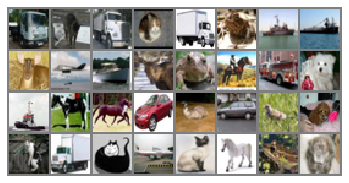

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [46]:
class MemNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MemNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 200, kernel_size=10),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(3)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(200, 200, 5),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Flatten()
        )
        
        self.dense1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
        )
        
        self.dense2 = nn.Sequential(
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
        )
        
        self.dense3 = nn.Sequential(
            nn.Linear(192, num_classes),
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x

In [47]:
num_epochs = 100
init_lr = 0.01

model = MemNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum = 0.9)  

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [50]:
total_step = len(trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in (enumerate(trainloader)):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    scheduler.step()
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 


211it [00:15, 68.49it/s]

135it [00:19, 68.24it/s]

Epoch [1/100], Step [1407/1407], Loss: 1.9551
Accuracy of the network on the 5000 validation images: 53.58 %
Epoch [2/100], Step [1407/1407], Loss: 1.8796
Accuracy of the network on the 5000 validation images: 57.82 %
Epoch [3/100], Step [1407/1407], Loss: 1.9382
Accuracy of the network on the 5000 validation images: 60.64 %
Epoch [4/100], Step [1407/1407], Loss: 2.0404
Accuracy of the network on the 5000 validation images: 59.8 %
Epoch [5/100], Step [1407/1407], Loss: 2.0711
Accuracy of the network on the 5000 validation images: 62.76 %
Epoch [6/100], Step [1407/1407], Loss: 1.7295
Accuracy of the network on the 5000 validation images: 64.44 %
Epoch [7/100], Step [1407/1407], Loss: 1.7242
Accuracy of the network on the 5000 validation images: 64.78 %
Epoch [8/100], Step [1407/1407], Loss: 1.8885
Accuracy of the network on the 5000 validation images: 64.92 %
Epoch [9/100], Step [1407/1407], Loss: 1.7056
Accuracy of the network on the 5000 validation images: 66.32 %
Epoch [10/100], Step

KeyboardInterrupt: 

In [44]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

780it [00:30, 71.43it/s]

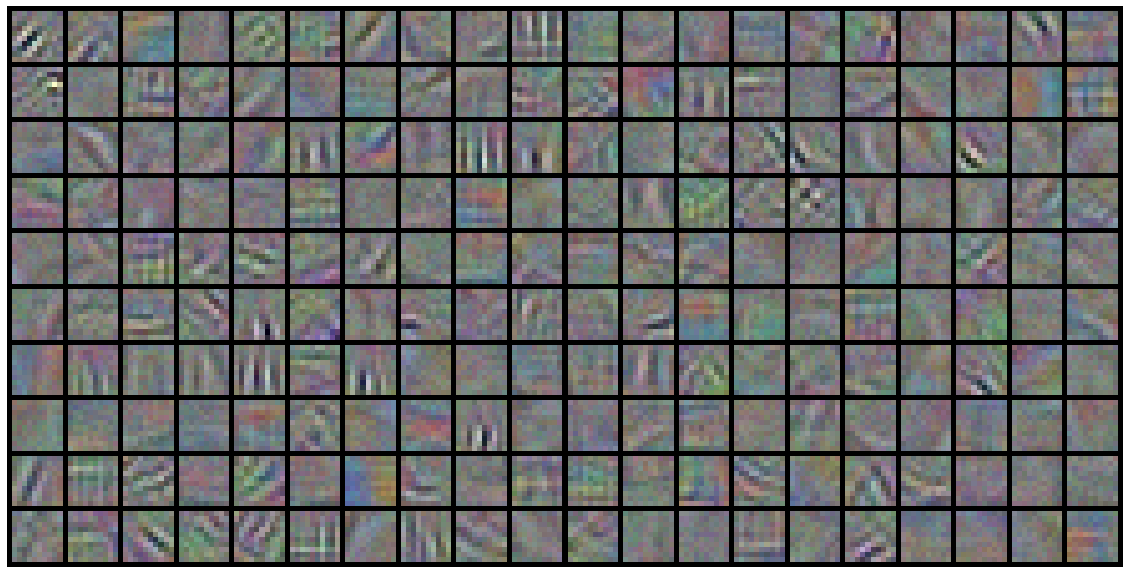

In [51]:
f = model.conv1[0].weight.data.clone().cpu()
visTensor(f, ch=0, allkernels=False, nrow=20)

plt.axis('off')
plt.ioff()
plt.show()

In [56]:
training_imgs = []

new_data = []
for i in trainset:
  new_data.append((i[0], random.randrange(0, 10)))




 19%|█▉        | 9498/50000 [00:13<00:11, 3408.24it/s]

In [57]:
class CustomDataset(Dataset):
    def __init__(self, imgs, transform=None, target_transform=None):
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        image, label = img
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [59]:
randYDataset = CustomDataset(new_data)

In [61]:
randy_trainloader = torch.utils.data.DataLoader(
    randYDataset, batch_size=batch_size)

In [63]:
num_epochs = 100
init_lr = 0.01

randY_model = MemNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(randY_model.parameters(), lr=init_lr, momentum = 0.9)  

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [64]:
total_step = len(randy_trainloader)

for epoch in range(num_epochs):
    for i, (images, labels) in (enumerate(randy_trainloader)):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = randY_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    scheduler.step()

Epoch [1/100], Step [1563/1563], Loss: 2.3104
Epoch [2/100], Step [1563/1563], Loss: 2.3012
Epoch [3/100], Step [1563/1563], Loss: 2.2919
Epoch [4/100], Step [1563/1563], Loss: 2.2663
Epoch [5/100], Step [1563/1563], Loss: 2.2180
Epoch [6/100], Step [1563/1563], Loss: 2.1284
Epoch [7/100], Step [1563/1563], Loss: 2.2257
Epoch [8/100], Step [1563/1563], Loss: 2.1923
Epoch [9/100], Step [1563/1563], Loss: 2.2640
Epoch [10/100], Step [1563/1563], Loss: 2.2057
Epoch [11/100], Step [1563/1563], Loss: 2.0946
Epoch [12/100], Step [1563/1563], Loss: 2.0233
Epoch [13/100], Step [1563/1563], Loss: 2.1229
Epoch [14/100], Step [1563/1563], Loss: 2.0090
Epoch [15/100], Step [1563/1563], Loss: 2.0768
Epoch [16/100], Step [1563/1563], Loss: 2.0921
Epoch [17/100], Step [1563/1563], Loss: 2.0139
Epoch [18/100], Step [1563/1563], Loss: 1.9441
Epoch [19/100], Step [1563/1563], Loss: 1.9017
Epoch [20/100], Step [1563/1563], Loss: 1.9214
Epoch [21/100], Step [1563/1563], Loss: 1.8779
Epoch [22/100], Step [

KeyboardInterrupt: 

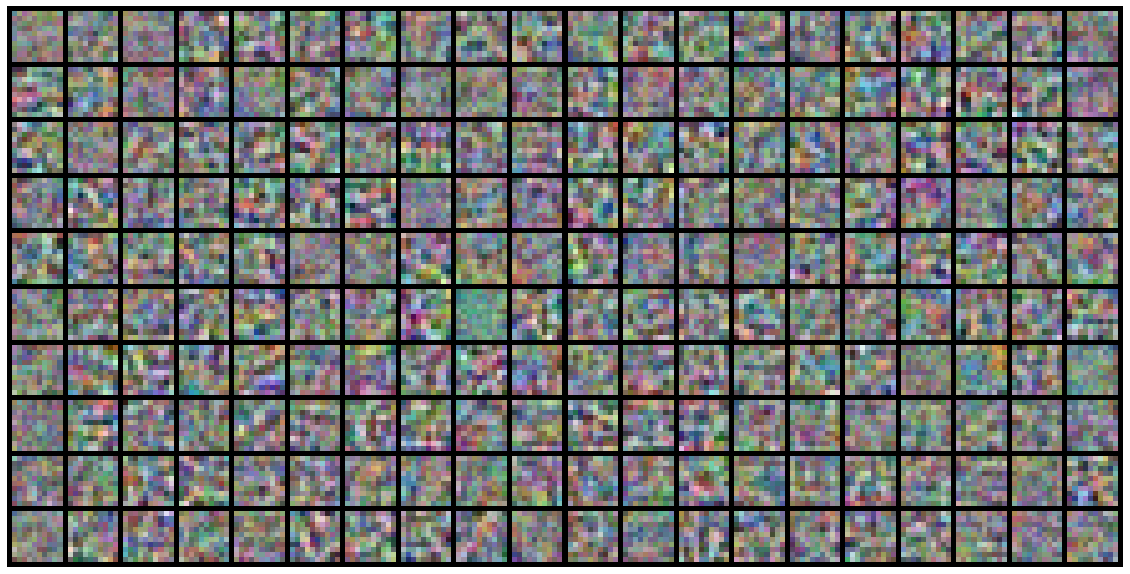

In [66]:
f = randY_model.conv1[0].weight.data.clone().cpu()
visTensor(f, ch=0, allkernels=False, nrow=20)

plt.axis('off')
plt.ioff()
plt.show()

In [67]:
torch.save(randY_model.state_dict(), "randY.pth")